# Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import re
import missingno as msno
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.float_format', '{:.0f}'.format)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/data" 

dacon_2101124.csv   sample_submission.csv  train_problem_data.csv
dacon_2101125.csv   test_err_data.csv	   train_quality_data.csv
dacon_2101126.csv   test_quality_data.csv
dacon_baseline.csv  train_err_data.csv


In [ ]:
train_problem = '/content/gdrive/MyDrive/data/train_problem_data.csv'
train_quality = '/content/gdrive/MyDrive/data/train_quality_data.csv'
train_err = '/content/gdrive/MyDrive/data/train_err_data.csv'
test_err = '/content/gdrive/MyDrive/data/test_err_data.csv'
test_quality = '/content/gdrive/MyDrive/data/test_quality_data.csv'
sample_submission = '/content/gdrive/MyDrive/data/sample_submission.csv'

In [ ]:
train_prob = pd.read_csv(train_problem)
train_qual = pd.read_csv(train_quality)
train_err = pd.read_csv(train_err)
test_err = pd.read_csv(test_err)
test_qual = pd.read_csv(test_quality)
sample_submission= pd.read_csv(sample_submission)

User-defined functions

In [ ]:
# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


# 2.Generating New Variables

## Preprocess

In [ ]:
# Remove rows with a missing value at the column of errcode.
train_err.drop(train_err.index[train_err["errcode"].isnull()], inplace=True)

AttributeError: ignored

In [ ]:
def preprocess_err(df):
  
    ########## Date #########
    time = df['time'].astype(str)
    df['month'] = [int(x[4:6]) for x in time ] 
    df['day']   = [int(x[6:8]) for x in time ] 
    df['hour']  = [int(x[8:10]) for x in time ] 

    ######### errcode #########
    err = df["errcode"]

    # New Variable (errcode_numeric) :: whether each variable is numeric or not
    df["errcode_numeric"] = err.map(lambda x: 1 if str(x).replace("-", "").isdigit() else 0)

    # New Variable (errcode_digit) :: the number of digits for each
    df["errcode_digits"] = err.map(lambda s: len(re.findall("[0-9]", str(s))) if str(s).isdigit() else 0)

    # errcode_sparse
    idx_errcode_100000 = list(err.value_counts()[err.value_counts() > 100000].index)
    df["errcode_sparse"] = err
    df.loc[~err.isin(idx_errcode_100000), "errcode_sparse"] = "sparse"

    #days
    df['datetime'] = df['time'].apply(make_datetime)

    min_day = df.datetime.min().date()

    df['days'] = df.loc[:,'datetime'].dt.date - min_day
    df['days'] = df['days'].dt.days
    
    return df


In [ ]:
def preprocess_qual(df):

    ########## Date #########
    time = df['time'].astype(str)
    df['month'] = [int(x[4:6]) for x in time ] 
    df['day']   = [int(x[6:8]) for x in time ] 
    df['hour']  = [int(x[8:10]) for x in time ] 

    quality_comma = []
    for j in ["quality_" + str(j) for j in range(0, 13)]:
        if (df[j].map(lambda x: len(re.findall(",", str(x))) > 0).sum()):
            display(j, test_qual[j].str.contains(",").sum())
            quality_comma.append(j)

    for j in quality_comma:
        idx_comma = df[j].str.contains(",", na=False)
        df[j][ idx_comma ] = df[j][ idx_comma ].map(lambda x: str(x).split(",")[0])

    for j in df.filter(regex="quality").columns:
        df[j] = df[j].astype(float)

    #days
    df['datetime'] = df['time'].apply(make_datetime)

    min_day = df.datetime.min().date()

    df['days'] = df.loc[:,'datetime'].dt.date - min_day
    df['days'] = df['days'].dt.days

    df.rename(columns = {'fwver':'qual_fwver', 'month':'qual_month', 'day':'qual_day', 'hour':'qual_hour',
                         'days':'qual_days'}, inplace = True)

    return df

In [ ]:
train_err = preprocess_err(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,month,day,hour,errcode_numeric,errcode_digits,errcode_sparse,datetime,days
0,10000,20201101025616,model_3,05.15.2138,15,1,11,1,2,1,1,1,2020-11-01 02:00:00,1
1,10000,20201101030309,model_3,05.15.2138,12,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
2,10000,20201101030309,model_3,05.15.2138,11,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
3,10000,20201101050514,model_3,05.15.2138,16,1,11,1,5,1,1,1,2020-11-01 05:00:00,1
4,10000,20201101050515,model_3,05.15.2138,4,0,11,1,5,1,1,0,2020-11-01 05:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,11,30,16,1,1,1,2020-11-30 16:00:00,30
16554659,24999,20201130172625,model_3,05.15.2138,16,1,11,30,17,1,1,1,2020-11-30 17:00:00,30
16554660,24999,20201130172625,model_3,05.15.2138,4,0,11,30,17,1,1,0,2020-11-30 17:00:00,30
16554661,24999,20201130172631,model_3,05.15.2138,4,0,11,30,17,1,1,0,2020-11-30 17:00:00,30


In [ ]:
test_err = preprocess_err(test_err)

,user_id,time,model_nm,fwver,errtype,errcode,month,day,hour,errcode_numeric,errcode_digits,errcode_sparse,datetime,days
0,30000,20201101030227,model_1,04.16.3553,31,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
1,30000,20201101030227,model_1,04.16.3553,33,2,11,1,3,1,1,2,2020-11-01 03:00:00,1
2,30000,20201101030228,model_1,04.16.3553,15,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
3,30000,20201101030256,model_1,04.16.3553,22,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
4,30000,20201101030300,model_1,04.16.3553,11,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16532643,44998,20201130210050,model_1,04.16.3553,40,0,11,30,21,1,1,0,2020-11-30 21:00:00,30
16532644,44998,20201130211831,model_1,04.16.3553,31,1,11,30,21,1,1,1,2020-11-30 21:00:00,30
16532645,44998,20201130211832,model_1,04.16.3553,15,1,11,30,21,1,1,1,2020-11-30 21:00:00,30
16532646,44998,20201130212259,model_1,04.16.3553,16,1,11,30,21,1,1,1,2020-11-30 21:00:00,30


In [ ]:
train_qual = preprocess_qual(train_qual)

'quality_5'

3876

'quality_7'

4488

'quality_8'

36

'quality_9'

1488

'quality_10'

39324

In [ ]:
test_qual = preprocess_qual(test_qual)

'quality_1'

1

'quality_5'

3876

'quality_7'

4488

'quality_8'

36

'quality_9'

1488

'quality_10'

39324

In [ ]:
test_err.to_csv('gdrive/MyDrive/test_err_made_210125.csv',index=False)

In [ ]:
train_err.to_csv('gdrive/MyDrive/train_err_made_210125.csv',index=False)

,user_id,time,model_nm,fwver,errtype,errcode,month,day,hour,errcode_numeric,errcode_digits,errcode_sparse,datetime,days
0,10000,20201101025616,model_3,05.15.2138,15,1,11,1,2,1,1,1,2020-11-01 02:00:00,1
1,10000,20201101030309,model_3,05.15.2138,12,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
2,10000,20201101030309,model_3,05.15.2138,11,1,11,1,3,1,1,1,2020-11-01 03:00:00,1
3,10000,20201101050514,model_3,05.15.2138,16,1,11,1,5,1,1,1,2020-11-01 05:00:00,1
4,10000,20201101050515,model_3,05.15.2138,4,0,11,1,5,1,1,0,2020-11-01 05:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,11,30,16,1,1,1,2020-11-30 16:00:00,30
16554659,24999,20201130172625,model_3,05.15.2138,16,1,11,30,17,1,1,1,2020-11-30 17:00:00,30
16554660,24999,20201130172625,model_3,05.15.2138,4,0,11,30,17,1,1,0,2020-11-30 17:00:00,30
16554661,24999,20201130172631,model_3,05.15.2138,4,0,11,30,17,1,1,0,2020-11-30 17:00:00,30


In [ ]:
test_err = pd.read_csv('gdrive/MyDrive/test_err_made_210125.csv')

In [ ]:
train_err = pd.read_csv('gdrive/MyDrive/train_err_made_210125.csv')

In [ ]:
test_qual.to_csv('gdrive/MyDrive/test_qual_made_210125.csv',index=False)

In [ ]:
train_qual.to_csv('gdrive/MyDrive/train_qual_made_210125.csv',index=False)

,time,user_id,qual_fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,qual_month,qual_day,qual_hour,datetime,qual_days
0,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0,11,29,9,2020-11-29 09:00:00,29
1,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0,11,29,9,2020-11-29 09:00:00,29
2,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0,11,29,9,2020-11-29 09:00:00,29
3,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0,11,29,9,2020-11-29 09:00:00,29
4,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0,11,29,9,2020-11-29 09:00:00,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0,0,0,0,0,1,0,0,0,0,17,0,0,11,24,3,2020-11-24 03:00:00,24
828620,20201124033000,24997,04.22.1778,0,0,0,0,0,0,0,0,0,0,17,0,0,11,24,3,2020-11-24 03:00:00,24
828621,20201124033000,24997,04.22.1778,0,0,0,0,0,3,0,0,0,0,17,0,0,11,24,3,2020-11-24 03:00:00,24
828622,20201124033000,24997,04.22.1778,0,0,0,0,0,0,0,0,0,0,17,0,0,11,24,3,2020-11-24 03:00:00,24


In [ ]:
test_qual = pd.read_csv('gdrive/MyDrive/test_qual_made_210125.csv')

In [ ]:
train_qual = pd.read_csv('gdrive/MyDrive/train_qual_made_210125.csv')

### FEATURE TYPE

In [ ]:
print(train_err.head(2))
print(train_qual.head(2))

   user_id            time model_nm  ... errcode_sparse            datetime days
0    10000  20201101025616  model_3  ...              1 2020-11-01 02:00:00    1
1    10000  20201101030309  model_3  ...              1 2020-11-01 03:00:00    1

[2 rows x 14 columns]
             time  user_id  ...            datetime  qual_days
0  20201129090000    10000  ... 2020-11-29 09:00:00         29
1  20201129090000    10000  ... 2020-11-29 09:00:00         29

[2 rows x 21 columns]


In [ ]:
print(train_err.columns)
print(train_qual.columns)
print(test_err.columns)
print(test_qual.columns)

Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'month',
       'day', 'hour', 'errcode_numeric', 'errcode_digits', 'errcode_sparse',
       'datetime', 'days'],
      dtype='object')
Index(['time', 'user_id', 'qual_fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'qual_month', 'qual_day', 'qual_hour', 'datetime', 'qual_days'],
      dtype='object')
Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'month',
       'day', 'hour', 'errcode_numeric', 'errcode_digits', 'errcode_sparse',
       'datetime', 'days'],
      dtype='object')
Index(['time', 'user_id', 'qual_fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'qual_month', 'qual_day', 'qual_hour'

In [ ]:
FEATURES = ["date", "month", "day", "hour"]
FEATURES_CONTINUOUS = ["date", "month", "day", "hour",
                       "quality_0", "quality_1", "quality_2", "quality_3", "quality_4", "quality_5",
                       "quality_6", "quality_7", "quality_8", "quality_9", "quality_10",
                       "quality_11", "quality_12"]
FEATURES_CATEGORICAL = ["model_nm", "fwver", "errtype",
                         "errcode_numeric", "errcode_digits", "errcode_sparse"]
TARGET = "problem"

### Encoder

In [ ]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [ ]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
def isnan(value):
    try:
        import math
        return math.isnan(float(value))
    except:
        return False



In [ ]:
def encode_cat(train_df, test_df, var, type):
  
    uni_train_var = train_df[var].unique()
    uni_test_var =  test_df[var].unique()

    li1 = [x for x in uni_train_var if x in uni_test_var]
    li2 = [x for x in uni_train_var if x not in uni_test_var]
    li3 = [x for x in uni_test_var if x not in uni_train_var]
    co_uni_var = np.unique(np.asarray(li1+li2+li3))
    co_uni_var.sort()
    co_uni_var = co_uni_var.astype(str)

    if type == 1 : 
      df = train_df
      user_number = train_user_number
      user_id_min = train_user_id_min 
    elif type == 2  :
      df = test_df
      user_number = test_user_number
      user_id_min = test_user_id_min


    id_var = df[['user_id',var]].values
    encode = np.zeros((user_number, co_uni_var.shape[0]))

    for person_idx, val in tqdm(id_var):
      if isnan(val):
        col = encode.shape[1] - 1
        encode[np.int(person_idx - user_id_min), col] += 1
      else :
        col = np.int(np.where(co_uni_var == str(val))[0])
        encode[np.int(person_idx - user_id_min), col] += 1

    pdf = pd.DataFrame(encode, columns=[str(var) + '_' + str(x) for x in co_uni_var])

    return(pdf)
  


In [ ]:
def npmean(x):
  return(np.mean(x))

def npmin(x):
  return(np.min(x))

def npmax(x):
  return(np.max(x))

def npstd(x):
  return(np.std(x))

In [ ]:
def encode_qual_time(df):
  err_time_encode = df.filter(regex="month|day|hour|user_id|quality_[0-9]+").groupby(['user_id']).agg([npmean,npmin,npmax, npstd])
  err_time_encode.columns = ["_".join(x) for x in err_time_encode.columns.ravel()]
  return(err_time_encode)

In [ ]:
# train_err category encode
model_pd = encode_cat(train_err, test_err, "model_nm", 1)
fwver_pd = encode_cat(train_err, test_err, "fwver", 1)
errtype_pd = encode_cat(train_err, test_err, "errtype", 1)
errcode_numeric_pd = encode_cat(train_err, test_err, "errcode_numeric", 1)
errcode_digits_pd = encode_cat(train_err, test_err, "errcode_digits", 1)
errcode_sparse_pd = encode_cat(train_err,test_err, "errcode_sparse", 1)

 53%|█████▎    | 8845263/16554662 [00:55<00:47, 163015.80it/s]

KeyboardInterrupt: ignored

In [ ]:
# test_err category encode
test_model_pd = encode_cat(train_err, test_err, "model_nm", 2)
test_fwver_pd =  encode_cat(train_err, test_err, "fwver", 2)
test_errtype_pd = encode_cat(train_err, test_err, "errtype", 2)
test_errcode_numeric_pd = encode_cat(train_err, test_err, "errcode_numeric", 2)
test_errcode_digits_pd = encode_cat(train_err, test_err, "errcode_digits", 2)
test_errcode_sparse_pd = encode_cat(train_err, test_err, "errcode_sparse", 2)

100%|██████████| 16532648/16532648 [01:50<00:00, 149250.09it/s]


In [ ]:
# train_qual category encode
qual_fwver_pd = encode_cat(train_qual, test_qual, "qual_fwver", 1)
test_qual_fwver_pd = encode_cat(train_qual, test_qual, "qual_fwver", 2)

NameError: ignored

In [ ]:
train_err_time = encode_qual_time(train_err)
test_err_time = encode_qual_time(test_err)

In [ ]:
train_qual_time = encode_qual_time(train_qual)
test_qual_time = encode_qual_time(test_qual)

In [ ]:
def err_comb(model, fwver, errtype, errcode_numeric, errcode_digits, errcode_sparse, err_time):

    err_encode1 = pd.concat([model, fwver, errtype, errcode_numeric, errcode_digits, errcode_sparse], axis=1).reset_index()
    err_encode1['user_id']=err_encode1['index']+10000
    err_encode1.drop(["index"], axis=1, inplace=True)
    err_encode = pd.merge(err_encode1, err_time, on="user_id" ,how="left")

    cols = [col for col in err_encode if col!='user_id']
    err_encode = err_encode[cols]

    return(err_encode)

In [ ]:
train_err_encode = err_comb(model_pd, fwver_pd, errtype_pd, errcode_numeric_pd, errcode_digits_pd, errcode_sparse_pd, train_err_time)

NameError: ignored

In [ ]:
# days_pd = train_err_time.iloc[:,12:17].reset_index()
# train_err_encode2 = pd.concat([train_err_encode,days_pd], axis=1)
# train_err_encode = train_err_encode2

In [ ]:
# days_pd = train_qual_time.iloc[:,64:68].reset_index()
# train_qual_encode2 = pd.concat([train_qual_encode,days_pd], axis=1)
# train_qual_encode = train_qual_encode2

In [ ]:
# days_pd = test_err_time.reset_index()
# test_err_encode2 = pd.concat([test_err_encode.iloc[:,:122],days_pd], axis=1)
# test_err_encode = test_err_encode2

In [ ]:
# days_pd = test_qual_time.iloc[:,64:68].reset_index()
# test_qual_encode2 = pd.concat([test_qual_encode,days_pd], axis=1)
# test_qual_encode = test_qual_encode2

In [ ]:
test_err_encode = err_comb(test_model_pd, test_fwver_pd, test_errtype_pd, test_errcode_numeric_pd, test_errcode_digits_pd, test_errcode_sparse_pd, test_err_time)

In [ ]:
def qual_comb(fwver, qual_time, type ):
      if type==1 :
        user_id_min = train_user_id_min  
      elif type==2:
        user_id_min = test_user_id_min

      qual_encode1 = fwver.reset_index()
      qual_encode1['user_id']= qual_encode1['index']+ user_id_min
      qual_encode1.drop(["index"], axis=1, inplace=True)
      qual_encode = pd.merge(qual_encode1, qual_time,on="user_id" ,how="left")

      cols = [col for col in qual_encode if col!='user_id']
      qual_encode = qual_encode[cols]
      
      return(qual_encode)


In [ ]:
train_qual_encode = qual_comb(qual_fwver_pd, train_qual_time,1)

In [ ]:
test_qual_encode = qual_comb(test_qual_fwver_pd, test_qual_time,2)

model_nm recode

In [ ]:
def recode(df) :
  for j in tqdm(df.filter(regex="model_nm").columns):
    df.loc[ df[j] > 0, j] = 1
  
  return(df)

In [ ]:
train_err_encode2 = recode(train_err_encode)
test_err_encode2 = recode(test_err_encode)

,model_nm_model_0,model_nm_model_1,model_nm_model_2,model_nm_model_3,model_nm_model_4,model_nm_model_5,model_nm_model_6,model_nm_model_7,model_nm_model_8,fwver_03.11.1141,fwver_03.11.1149,fwver_03.11.1167,fwver_04.16.2641,fwver_04.16.3345,fwver_04.16.3439,fwver_04.16.3553,fwver_04.16.3569,fwver_04.16.3571,fwver_04.22.1170,fwver_04.22.1442,fwver_04.22.1448,fwver_04.22.1478,fwver_04.22.1608,fwver_04.22.1656,fwver_04.22.1666,fwver_04.22.1684,fwver_04.22.1750,fwver_04.22.1772,fwver_04.22.1778,fwver_04.33.1095,fwver_04.33.1125,fwver_04.33.1149,fwver_04.33.1171,fwver_04.33.1185,fwver_04.33.1261,fwver_04.73.2237,fwver_04.73.2569,fwver_04.73.2571,fwver_04.73.2577,fwver_04.82.1684,...,errcode_digits_0,errcode_digits_1,errcode_digits_2,errcode_digits_3,errcode_digits_4,errcode_digits_5,errcode_digits_6,errcode_digits_7,errcode_digits_8,errcode_sparse_0,errcode_sparse_1,errcode_sparse_14,errcode_sparse_2,errcode_sparse_79,errcode_sparse_80,errcode_sparse_84,errcode_sparse_85,errcode_sparse_B-A8002,errcode_sparse_NFANDROID2,errcode_sparse_active,errcode_sparse_connection fail to establish,errcode_sparse_connection timeout,errcode_sparse_sparse,errcode_sparse_standby,month_npmean,month_npmin,month_npmax,month_npstd,day_npmean,day_npmin,day_npmax,day_npstd,hour_npmean,hour_npmin,hour_npmax,hour_npstd,days_npmean,days_npmin,days_npmax,days_npstd
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,317,0,0,0,0,0,0,0,104,212,0,1,0,0,0,0,0,0,0,0,0,0,0,11,11,11,0,15,1,30,9,8,0,23,7,15,1,30,9
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,379,1986,0,0,0,0,0,...,861,1487,17,0,0,0,0,0,0,183,1274,16,7,0,0,0,0,53,56,126,0,0,25,625,11,11,11,0,22,1,30,8,15,0,23,6,22,1,30,8
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,305,0,0,0,0,0,0,0,132,172,0,1,0,0,0,0,0,0,0,0,0,1,0,11,11,11,0,14,1,30,8,13,0,23,7,14,1,30,8
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,225,0,0,0,0,0,...,23,278,3,0,2,0,0,0,0,42,229,3,3,0,0,0,0,1,1,12,0,7,8,0,11,11,11,0,16,1,30,9,10,0,23,8,16,1,30,9
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,645,0,132,0,0,0,0,0,0,0,0,0,0,0,...,120,645,12,0,0,0,0,0,0,98,529,9,14,0,0,0,0,0,0,7,1,104,10,5,11,11,11,0,15,1,30,9,13,0,23,7,15,1,30,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194,0,0,0,0,0,...,21,155,18,0,0,0,0,0,0,22,125,14,4,0,0,0,0,2,7,4,0,0,8,8,11,11,11,0,25,20,30,3,14,0,23,8,25,20,30,3
14996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,11,11,11,0,30,30,30,0,16,16,16,0,30,30,30,0
14997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,465,0,361,0,0,0,0,0,0,0,0,0,0,0,...,46,777,3,0,0,0,0,0,0,146,598,2,20,0,0,0,0,8,8,4,0,13,16,11,11,11,11,0,16,1,30,9,11,0,23,7,16,1,30,9
14998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,147,0,0,0,0,0,0,0,0,0,0,0,...,2,152,1,0,0,0,0,0,0,13,125,1,12,0,0,0,0,0,0,1,0,0,3,0,11,11,11,0,14,1,30,8,9,2,21,6,14,1,30,8


In [ ]:
train_comb_encode =pd.concat([train_err_encode2, train_qual_encode], axis=1)

In [ ]:
test_comb_encode =pd.concat([test_err_encode2, test_qual_encode], axis=1)

In [ ]:
print(train_err_encode.shape)
print(test_err_encode.shape)
print(train_qual_encode.shape)
print(test_qual_encode.shape)
print(train_comb_encode.shape)
print(test_comb_encode.shape)

(15000, 234)
(14999, 234)


In [ ]:
train_err_encode2.to_csv("gdrive/MyDrive/train_err_encode_pd_210125_2.csv",index=False)
train_qual_encode.to_csv("gdrive/MyDrive/train_qual_encode_pd_210125.csv",index=False)

In [ ]:
train_comb_encode.to_csv("gdrive/MyDrive/train_comb_encode_pd_210125_2.csv",index=False)

,model_nm_model_0,model_nm_model_1,model_nm_model_2,model_nm_model_3,model_nm_model_4,model_nm_model_5,model_nm_model_6,model_nm_model_7,model_nm_model_8,fwver_03.11.1141,fwver_03.11.1149,fwver_03.11.1167,fwver_04.16.2641,fwver_04.16.3345,fwver_04.16.3439,fwver_04.16.3553,fwver_04.16.3569,fwver_04.16.3571,fwver_04.22.1170,fwver_04.22.1442,fwver_04.22.1448,fwver_04.22.1478,fwver_04.22.1608,fwver_04.22.1656,fwver_04.22.1666,fwver_04.22.1684,fwver_04.22.1750,fwver_04.22.1772,fwver_04.22.1778,fwver_04.33.1095,fwver_04.33.1125,fwver_04.33.1149,fwver_04.33.1171,fwver_04.33.1185,fwver_04.33.1261,fwver_04.73.2237,fwver_04.73.2569,fwver_04.73.2571,fwver_04.73.2577,fwver_04.82.1684,...,quality_7_npmean,quality_7_npmin,quality_7_npmax,quality_7_npstd,quality_8_npmean,quality_8_npmin,quality_8_npmax,quality_8_npstd,quality_9_npmean,quality_9_npmin,quality_9_npmax,quality_9_npstd,quality_10_npmean,quality_10_npmin,quality_10_npmax,quality_10_npstd,quality_11_npmean,quality_11_npmin,quality_11_npmax,quality_11_npstd,quality_12_npmean,quality_12_npmin,quality_12_npmax,quality_12_npstd,qual_month_npmean,qual_month_npmin,qual_month_npmax,qual_month_npstd,qual_day_npmean,qual_day_npmin,qual_day_npmax,qual_day_npstd,qual_hour_npmean,qual_hour_npmin,qual_hour_npmax,qual_hour_npstd,qual_days_npmean,qual_days_npmin,qual_days_npmax,qual_days_npstd
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,4,8,2,0,0,0,0,0,0,0,0,11,11,11,0,30,29,30,0,15,9,21,6,30,29,30,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,379,1986,0,0,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17,4,30,9
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,0,44,14,0,0,0,0,0,0,1,0,4,0,8,2,-0,-1,0,0,0,0,0,0,11,11,11,0,17,4,30,9,6,0,14,6,3,2,4,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,225,0,0,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19,19,19,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,645,0,132,0,0,0,0,0,0,0,0,0,0,0,...,44,0,87,44,0,0,0,0,0,0,0,0,2,1,3,1,-0,-1,0,0,0,0,0,0,11,11,11,0,3,2,4,1,18,12,23,6,18,9,27,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,0,-0,-1,0,0,0,0,0,0,11,11,11,0,28,28,29,0,10,0,20,10,nan,nan,nan,nan
14996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
14997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,465,0,361,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,10,2,17,8,-0,-1,0,0,0,0,0,0,11,11,11,0,16,8,24,8,13,3,23,10,nan,nan,nan,nan
14998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,147,0,0,0,0,0,0,0,0,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
train_err_encode = pd.read_csv("gdrive/MyDrive/train_err_encode_pd_210125.csv")
train_qual_encode = pd.read_csv("gdrive/MyDrive/train_qual_encode_pd_210125.csv")
train_comb_encode = pd.read_csv("gdrive/MyDrive/train_comb_encode_pd_210125_2.csv")
test_err_encode = pd.read_csv("gdrive/MyDrive/test_err_encode_pd_210125.csv")
test_qual_encode = pd.read_csv("gdrive/MyDrive/test_qual_encode_pd_210125.csv")

In [ ]:
test_err_encode2.to_csv("gdrive/MyDrive/test_err_encode_pd_210125_2.csv",index=False)
test_qual_encode.to_csv("gdrive/MyDrive/test_qual_encode_pd_210125.csv",index=False)

In [ ]:
test_comb_encode.to_csv("gdrive/MyDrive/test_comb_encode_pd_210125_2.csv",index=False)

In [ ]:
train_comb_encode = pd.read_csv("gdrive/MyDrive/train_comb_encode_pd_210125_2.csv")
test_comb_encode = pd.read_csv("gdrive/MyDrive/test_comb_encode_pd_210125_2.csv")

In [ ]:
print(train_comb_encode.shape)
print(test_comb_encode.shape)

,model_nm_model_0,model_nm_model_1,model_nm_model_2,model_nm_model_3,model_nm_model_4,model_nm_model_5,model_nm_model_6,model_nm_model_7,model_nm_model_8,fwver_03.11.1141,fwver_03.11.1149,fwver_03.11.1167,fwver_04.16.2641,fwver_04.16.3345,fwver_04.16.3439,fwver_04.16.3553,fwver_04.16.3569,fwver_04.16.3571,fwver_04.22.1170,fwver_04.22.1442,fwver_04.22.1448,fwver_04.22.1478,fwver_04.22.1608,fwver_04.22.1656,fwver_04.22.1666,fwver_04.22.1684,fwver_04.22.1750,fwver_04.22.1772,fwver_04.22.1778,fwver_04.33.1095,fwver_04.33.1125,fwver_04.33.1149,fwver_04.33.1171,fwver_04.33.1185,fwver_04.33.1261,fwver_04.73.2237,fwver_04.73.2569,fwver_04.73.2571,fwver_04.73.2577,fwver_04.82.1684,...,quality_7_npmean,quality_7_npmin,quality_7_npmax,quality_7_npstd,quality_8_npmean,quality_8_npmin,quality_8_npmax,quality_8_npstd,quality_9_npmean,quality_9_npmin,quality_9_npmax,quality_9_npstd,quality_10_npmean,quality_10_npmin,quality_10_npmax,quality_10_npstd,quality_11_npmean,quality_11_npmin,quality_11_npmax,quality_11_npstd,quality_12_npmean,quality_12_npmin,quality_12_npmax,quality_12_npstd,qual_month_npmean,qual_month_npmin,qual_month_npmax,qual_month_npstd,qual_day_npmean,qual_day_npmin,qual_day_npmax,qual_day_npstd,qual_hour_npmean,qual_hour_npmin,qual_hour_npmax,qual_hour_npstd,qual_days_npmean,qual_days_npmin,qual_days_npmax,qual_days_npstd
0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2320,0,367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,0,0,0,0,0,...,5,5,5,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,11,11,11,0,28,28,28,0,19,19,19,0,28,28,28,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,2,4,1,-0,-1,0,0,0,0,0,0,11,11,11,0,6,2,12,4,15,4,20,8,6,2,12,4
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,733,0,208,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,13,3,49,15,-0,-1,0,0,0,0,0,0,11,11,11,0,8,1,18,5,11,0,18,6,8,1,18,5
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,246,0,125,0,0,0,0,0,0,0,0,0,0,0,...,44,0,93,38,0,0,0,0,0,0,0,0,2,0,6,2,0,0,0,0,0,0,0,0,11,11,11,0,20,16,25,4,12,2,20,8,20,16,25,4
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,255,0,0,0,0,0,...,16,9,24,8,0,0,0,0,0,0,0,0,1,0,2,1,-0,-1,0,0,0,0,0,0,11,11,11,0,24,21,26,2,15,15,15,0,24,21,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,-1,-1,0,0,0,0,0,0,11,11,11,0,26,26,26,0,16,16,16,0,nan,nan,nan,nan
14995,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,474,0,0,0,0,0,0,0,0,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
14996,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1602,0,631,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,4,2,9,3,-0,-1,0,0,0,0,0,0,11,11,11,0,17,3,27,8,11,0,23,9,nan,nan,nan,nan
14997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21466,0,3205,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,3,10,4,0,0,0,0,0,0,0,0,11,11,11,0,14,2,25,12,20,18,21,2,nan,nan,nan,nan


## Modeling

In [ ]:
!pip install GPyOpt
from sklearn.model_selection import KFold
from GPyOpt.methods import BayesianOptimization
import time

gc.collect()

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 1.0MB 7.3MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83623 sha256=55311ad8fb25408537a74582ff3dfbae39694b275d9920966bc3ee0144d9754b
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633927 sha256=945f2490e95e1316a1e1c9abe743ba9cea81e2a43927ca36d9f9a3c40263fd65
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=1d1e52d1e4772a5367f009fa133c08a761aded21dfd124424eef303e75469765
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPyOpt GPy paramz


4499

In [ ]:
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1
problem.shape

(15000,)

In [ ]:
train_x = train_comb_encode.copy()
train_y = problem

In [ ]:
test_x = test_comb_encode.copy()

In [ ]:

# split_size = 0.35
# n_estimators = 1000
# metric = 'auc'
# ESR = 150
# seed = 20210124
# nfold = 10
# parameters = [2, 20, 1000, 0, 0, 0, 0.1, 0.1]
# 
# def f_pr_auc(probas_pred, y_true):
#     labels = y_true.get_label()
#     p, r, _ = precision_recall_curve(labels, probas_pred)
#     score = auc(r, p)
#     return "pr_auc", score, True


# Optimization objective 
def lgb_score(para):
    parameters = para[0]

    params = {
        # 'device':'gpu',
        'objective': 'binary',
        'metric': "auc",
        'learning_rate': 0.05, 
        'tree_learner': 'serial',
        'boost_from_average': 'true',
        # 'num_boost_round': n_estimators,
        'boosting_type': 'gbdt',#, 'goss', 'dart'],
        # 'max_depth': int(parameters[9]),
        'num_leaves': int(parameters[1]), 
        'n_estimators' : int(parameters[8]),
        # 'learning_rate' : parameters[10],
        # Tree Depth Regularization
        'subsample_for_bin': int(parameters[2]), # Number of samples for constructing bin
        'min_data_in_leaf': int(parameters[0]), # Minimum number of data need in a child(min_data_in_leaf) - Must be motified when using a smaller dataset
        'min_sum_hessian_in_leaf': parameters[7], # Prune by minimum hessian requirement - Minimum sum of instance weight(hessian) needed in a child(leaf)

        # Regularization L1/L2
        'reg_alpha': parameters[3], # L1 regularization term on weights (0 is no regular)
        'reg_lambda': parameters[4], # L2 regularization term on weights

        # Row/Column Sampling
        'bagging_fraction': parameters[5],# Percentage of rows used per iteration frequency.
        'bagging_freq': 1,# Iteration frequency to update the selected rows.
        'feature_fraction': parameters[6], # Percentage of columns used per iteration.


        # Dart Specific
    #     'max_drop': list(np.linspace(1, 70, 5).round(0).astype(int)), # Maximum number of dropped trees on one iteration.
    #     'rate_drop': list(np.linspace(0, .8, 10).round(2)), # Dropout - Probability to to drop a tree on one iteration.
    #     'skip_drop': list(np.linspace(.4, .6, 3).round(2)), # Probability of skipping any drop on one iteration. 
    #     'uniform_drop': [False], # Uniform weight application for trees.

        # Imbalanced Dependent Variable
        'is_unbalance': False, 

        'nthread': -1, # Multi-threading
        'verbose': -1, # Logging Iteration Progression
        # 'seed': seed # Seed for row sampling RNG.
    }
    
    modelstart= time.time()
    auc_scores = []
    k_fold = KFold(n_splits=5, shuffle=True)
    for train_idx, val_idx in k_fold.split(train_x):
        # train_idx, val_idx = list( k_fold.split(train_x) )[0]
        # split train, validation set
        X = train_x.iloc[train_idx,]
        y = train_y[train_idx,]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train, d_val],
                        valid_names=['train','valid'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                      
                        )
        
        
        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > 0.5, 1, 0)

        # cal scores
        auc_score = roc_auc_score(valid_y, valid_prob)
        auc_scores.append(auc_score)

    runtime = (time.time() - modelstart)/60

    # Get Metrics
    score = np.mean( auc_score )
    
    gpyopt_output.append(
        [
        score,
        params,
        runtime
        ]
    )

    return( np.array( score ) )



In [ ]:
bds = [ {'name': 'min_data_in_leaf', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'num_leaves', 'type': 'discrete', 'domain': (50, 500)},
        {'name': 'subsample_for_bin', 'type': 'continuous', 'domain': (10, 250)},
        {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'bagging_fraction', 'type': 'continuous', 'domain': (.01, 1)},
        {'name': 'feature_fraction', 'type': 'continuous', 'domain': (.01, 1)},
        {'name': 'min_sum_hessian_in_leaf', 'type': 'continuous', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 500)}
        # {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 100)},
        # {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.05)}

      ]

# seed = 20210123
# %xmode Verbose
gpyopt_output = []
optimizer = BayesianOptimization(f=lgb_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 maximize=True,
                                 exact_feval=True
                                 )


# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=50)
optimizer.plot_acquisition()


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[129]	train's auc: 0.87834	valid's auc: 0.806252
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[47]	train's auc: 0.836316	valid's auc: 0.799603
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[126]	train's auc: 0.87346	valid's auc: 0.809597
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[23]	train's auc: 0.823812	valid's auc: 0.788416
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[5]	train's auc: 0.777885	valid's auc: 0.761304
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[98]	train's auc: 0.902439	valid's auc: 0.815844
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[130]	train's auc: 0.916187	

In [ ]:
# Output
results = pd.DataFrame(gpyopt_output, columns = ['avg_auc', 'parameters', 'runtime'] )
results.to_csv("gpyopt_iterations_output.csv")
best_params = results['parameters'].iloc[np.argmax(results.avg_auc)]
best_params

{'bagging_fraction': 0.7990052858167516,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.40803330483126526,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_data_in_leaf': 62,
 'min_sum_hessian_in_leaf': 20.346377678728466,
 'n_estimators': 500,
 'nthread': -1,
 'num_leaves': 500,
 'objective': 'binary',
 'reg_alpha': 0.5482573493009615,
 'reg_lambda': 0.360582248897461,
 'subsample_for_bin': 174,
 'tree_learner': 'serial',
 'verbose': -1}

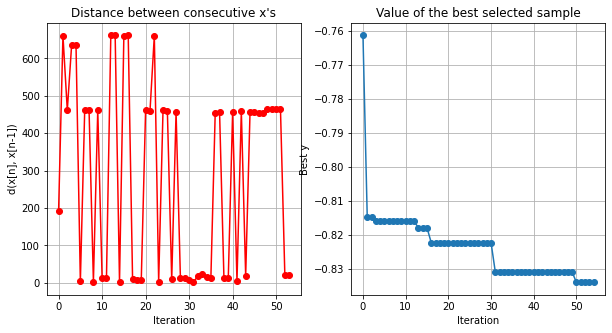

Best AUC: -0.8339801006641889
Best Parameters
{'bagging_fraction': 0.7990052858167516,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.40803330483126526,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_data_in_leaf': 62,
 'min_sum_hessian_in_leaf': 20.346377678728466,
 'n_estimators': 500,
 'nthread': -1,
 'num_leaves': 500,
 'objective': 'binary',
 'reg_alpha': 0.5482573493009615,
 'reg_lambda': 0.360582248897461,
 'subsample_for_bin': 174,
 'tree_learner': 'serial',
 'verbose': -1}


In [ ]:
import pprint

# Visualize Convergence
optimizer.plot_convergence()

print("Best AUC: {}".format(optimizer.fx_opt))
print("Best Parameters")
pprint.pprint(best_params)

Training until validation scores don't improve for 10 rounds.
[200]	train's auc: 0.95249
[400]	train's auc: 0.983611
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.990161


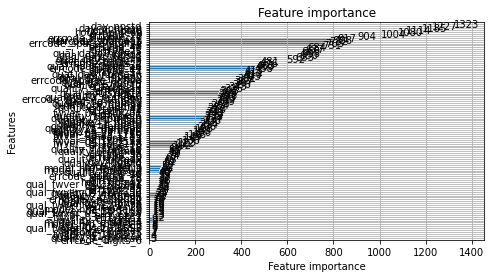

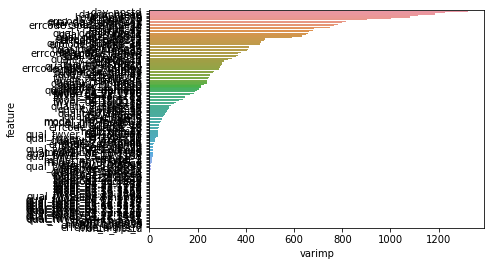

In [ ]:
d_train= lgb.Dataset(train_x, train_y)
bestmodel = lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train],
                        valid_names=['train'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        )

import seaborn as sns
## 변수 중요도 시각화 
lgb.plot_importance(bestmodel)
plt.show()
feature_importance = pd.DataFrame([bestmodel.feature_name() , bestmodel.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()

In [ ]:
all_features = feature_importance[["feature", "varimp"]].sort_values(by="varimp", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features['feature'][:200])

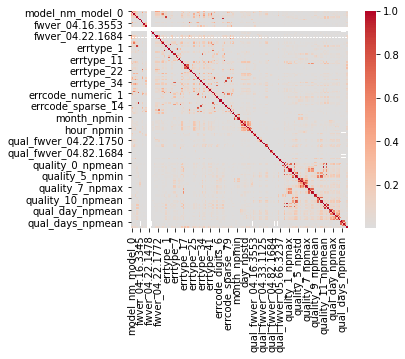

In [ ]:
li1 = [x for x in train_x.columns if x in important_features]
df = pd.concat([train_x[li1], pd.Series(train_y)], axis=1)
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, cmap="coolwarm", square=True, center=0)

In [ ]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.columns
# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)

0
[]


In [ ]:
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

148
['day_npstd', 'day_npmean', 'hour_npstd', 'hour_npmean', 'errtype_15', 'errtype_26', 'errcode_numeric_1', 'qual_days_npmean', 'errcode_sparse_1', 'errcode_sparse_sparse', 'errtype_22', 'errtype_40', 'errtype_31', 'errtype_5', 'qual_days_npmax', 'qual_days_npstd', 'errtype_11', 'qual_days_npmin', 'errcode_sparse_2', 'errcode_digits_2', 'errtype_33', 'qual_hour_npmean', 'errcode_sparse_14', 'errtype_41', 'errtype_14', 'qual_day_npmean', 'qual_hour_npmin', 'qual_day_npmax', 'errcode_sparse_active', 'quality_5_npstd', 'qual_day_npmin', 'errtype_17', 'quality_5_npmean', 'errtype_4', 'errtype_7', 'qual_hour_npstd', 'quality_6_npstd', 'quality_10_npmean', 'errcode_sparse_standby', 'quality_10_npmax', 'qual_day_npstd', 'qual_hour_npmax', 'quality_5_npmax', 'errtype_42', 'errtype_34', 'fwver_04.33.1261', 'errtype_6', 'quality_10_npmin', 'quality_0_npmean', 'quality_10_npstd', 'quality_1_npstd', 'quality_11_npstd', 'quality_6_npmean', 'quality_11_npmean', 'quality_1_npmean', 'fwver_04.22.177

In [ ]:
ft1 = [x for x in train_x.columns if x in features]
ft2 = [x for x in test_x.columns if x in features]
train_fts = train_x[ft1]
test_fts = test_x[ft2]

In [ ]:
train_x = train_fts.copy()
train_y = problem
test_x = test_fts.copy()

In [ ]:
# seed = 20210123
# %xmode Verbose
gpyopt_output = []
optimizer = BayesianOptimization(f=lgb_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 maximize=True,
                                 exact_feval=True
                                 )


# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=50)
optimizer.plot_acquisition()


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[81]	train's auc: 0.876451	valid's auc: 0.836309
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[105]	train's auc: 0.889233	valid's auc: 0.820108
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[119]	train's auc: 0.897157	valid's auc: 0.803726
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[94]	train's auc: 0.886356	valid's auc: 0.810736
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[107]	train's auc: 0.891294	valid's auc: 0.813475
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[105]	train's auc: 0.866708	valid's auc: 0.807063
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[178]	train's auc: 0.88

In [ ]:
# Output
results = pd.DataFrame(gpyopt_output, columns = ['avg_auc', 'parameters', 'runtime'] )
results.to_csv("gpyopt_iterations_output.csv")
best_params = results['parameters'].iloc[np.argmax(results.avg_auc)]
best_params

{'bagging_fraction': 0.9647300006963638,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6130746330039559,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_data_in_leaf': 44,
 'min_sum_hessian_in_leaf': 21.8196185772881,
 'n_estimators': 500,
 'nthread': -1,
 'num_leaves': 500,
 'objective': 'binary',
 'reg_alpha': 0.36954611957182293,
 'reg_lambda': 0.5039135252608372,
 'subsample_for_bin': 54,
 'tree_learner': 'serial',
 'verbose': -1}

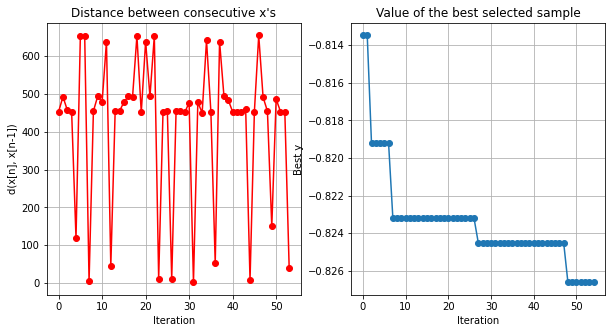

Best AUC: -0.8266223887517388
Best Parameters
{'bagging_fraction': 0.9647300006963638,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6130746330039559,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_data_in_leaf': 44,
 'min_sum_hessian_in_leaf': 21.8196185772881,
 'n_estimators': 500,
 'nthread': -1,
 'num_leaves': 500,
 'objective': 'binary',
 'reg_alpha': 0.36954611957182293,
 'reg_lambda': 0.5039135252608372,
 'subsample_for_bin': 54,
 'tree_learner': 'serial',
 'verbose': -1}


In [ ]:
import pprint

# Visualize Convergence
optimizer.plot_convergence()

print("Best AUC: {}".format(optimizer.fx_opt))
print("Best Parameters")
pprint.pprint(best_params)

Training until validation scores don't improve for 10 rounds.
[200]	train's auc: 0.957346
[400]	train's auc: 0.986726
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.992291


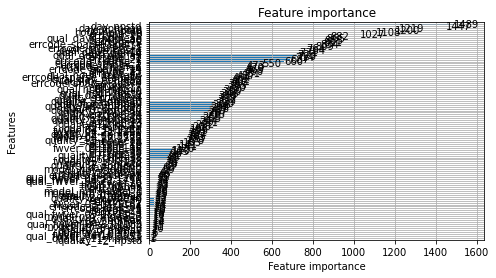

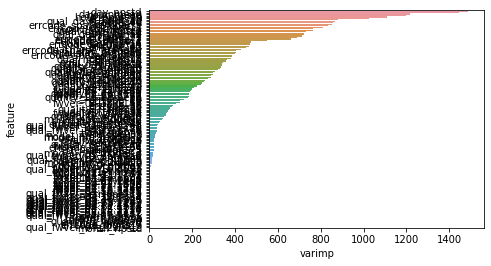

In [ ]:
d_train= lgb.Dataset(train_x, train_y)
bestmodel = lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train],
                        valid_names=['train'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        )

import seaborn as sns
## 변수 중요도 시각화 
lgb.plot_importance(bestmodel)
plt.show()
feature_importance = pd.DataFrame([bestmodel.feature_name() , bestmodel.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()

In [ ]:
lgb_models = []

nfold = 5
folds = KFold(n_splits=nfold, shuffle=True)
for fold_, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
  train_x_i = train_x.iloc[train_index,]
  train_y_i = train_y[train_index]

  val_x_i = train_x.iloc[valid_index,]
  val_y_i = train_y[valid_index]
  
  d_train= lgb.Dataset(train_x_i, train_y_i)
  d_val= lgb.Dataset(val_x_i, val_y_i)

  lgb_models.append( lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train, d_val],
                        valid_names=['train', 'val'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        ) )
  


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[67]	train's auc: 0.899226	val's auc: 0.812044
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[77]	train's auc: 0.899856	val's auc: 0.814211
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[151]	train's auc: 0.935459	val's auc: 0.819076
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[49]	train's auc: 0.885079	val's auc: 0.812095
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[102]	train's auc: 0.917983	val's auc: 0.810253


In [ ]:
# 예측
pred_y_list = []
for model in lgb_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [ ]:
pred_ensemble

array([[0.89128683],
       [0.23331187],
       [0.34413008],
       ...,
       [0.52754358],
       [0.87097495],
       [0.52801743]])

In [ ]:
sample_submission['problem'] = pred_ensemble.reshape(-1)

In [ ]:
sample_submission.to_csv("gdrive/MyDrive/data/dacon_2101127.csv", index = False)
sample_submission

,user_id,problem
0,30000,1
1,30001,0
2,30002,0
3,30003,1
4,30004,1
...,...,...
14994,44994,0
14995,44995,0
14996,44996,1
14997,44997,1
